In [1]:
import pandas as pd          
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime    
from pandas import Series 
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 运用机器学习的思路寻找影响需求的特征

In [2]:
df  = pd.read_csv("sales_data.csv")
df.head()


,order_date,order_date.1,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,...,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_workday,is_holiday,sales,Year Month,year,month
0,2015-09-01,2015-09-01,104,22069,307,403,1,1114.0,19,2015,...,0,0,0,0,1,0,21166.0,2015-09,2015,9
1,2015-09-01,2015-09-01,104,20028,301,405,1,1012.0,12,2015,...,0,0,0,0,1,0,12144.0,2015-09,2015,9
2,2015-09-02,2015-09-02,104,21183,307,403,0,428.0,109,2015,...,0,0,0,0,1,0,46652.0,2015-09,2015,9
3,2015-09-02,2015-09-02,104,20448,308,404,0,962.0,3,2015,...,0,0,0,0,1,0,2886.0,2015-09,2015,9
4,2015-09-02,2015-09-02,104,21565,307,403,1,1400.0,3,2015,...,0,0,0,0,1,0,4200.0,2015-09,2015,9


In [4]:
df.shape

(583102, 26)

In [5]:
df.columns

Index(['order_date', 'order_date.1', 'sales_region_code', 'item_code',
       'first_cate_code', 'second_cate_code', 'sales_chan_name', 'item_price',
       'ord_qty', 'Year', 'Month', 'day', 'day of the week', 'quarter',
       'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end',
       'is_year_start', 'is_year_end', 'is_workday', 'is_holiday', 'sales',
       'Year Month', 'year', 'month'],
      dtype='object')

In [6]:
df["order_date"]=df["order_date"].apply(pd.to_datetime,format='%Y-%m-%d')

In [7]:
df = df.drop(['order_date.1'],axis=1)

In [8]:
dff = df

In [9]:
#移动索引并查找差异
dff['step'] = dff['order_date']-dff['order_date'].shift(1)
zero = np.timedelta64(0, 's')       
dff['step'][0] = np.timedelta64(0, 's')#将第一个变量从naT更改为零
dff['step'] = dff['step'].apply(lambda x: x>zero).cumsum()
dff.head()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_12656\2338902091.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['step'][0] = np.timedelta64(0, 's')#将第一个变量从naT更改为零


,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,...,is_quarter_end,is_year_start,is_year_end,is_workday,is_holiday,sales,Year Month,year,month,step
0,2015-09-01,104,22069,307,403,1,1114.0,19,2015,9,...,0,0,0,1,0,21166.0,2015-09,2015,9,0
1,2015-09-01,104,20028,301,405,1,1012.0,12,2015,9,...,0,0,0,1,0,12144.0,2015-09,2015,9,0
2,2015-09-02,104,21183,307,403,0,428.0,109,2015,9,...,0,0,0,1,0,46652.0,2015-09,2015,9,1
3,2015-09-02,104,20448,308,404,0,962.0,3,2015,9,...,0,0,0,1,0,2886.0,2015-09,2015,9,1
4,2015-09-02,104,21565,307,403,1,1400.0,3,2015,9,...,0,0,0,1,0,4200.0,2015-09,2015,9,1


# 构建模型

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing


from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score,accuracy_score,log_loss
from xgboost import XGBRegressor
import lightgbm as lgb
#optimizer 

from functools import partial

In [173]:
#pre = pd.read_csv('predict_sku0.csv')

In [47]:
train_df = dff

In [48]:
train_df.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty', 'Year',
       'Month', 'day', 'day of the week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'is_workday', 'is_holiday', 'sales', 'year', 'month',
       'step'],
      dtype='object')

In [49]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [50]:
train_df['step^2'] = train_df['step']**2

In [51]:
features = train_df[['sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price','Year',
       'Month', 'day', 'day of the week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'is_workday', 'is_holiday', 'sales','step', 'step^2']]
targets = train_df['ord_qty'] 

In [52]:
# split data
X_train,X_val,y_train,y_val = train_test_split(features,targets,test_size=0.05,shuffle=False)

In [53]:
model2 = LinearRegression()
model2.fit(X_train, y_train)

LinearRegression()

In [54]:
smape(y_val,model2.predict(X_val))

89.17576112785504

In [55]:
print("地  区",train_df.sales_region_code.unique())
print("大类别",train_df.first_cate_code.unique())
print("细类别",train_df.second_cate_code.unique())

地  区 [104 102 101 105 103]
大类别 [301 303 306 305 302 307 308 304]
细类别 [405 401 407 402 412 408 403 410 404 409 406 411]


**一个地区一个地区去检验
从101改至105，依次进行即可，之后可以根据需求对大类别特征，细类别特征进行探讨
就修改下方region_1 = region_1[(region_1["sales_region_code"]==101)]部分即可**

In [56]:
region_1 = df.groupby(['sales_region_code', 'first_cate_code','second_cate_code','item_code']).sum().reset_index()

In [57]:
region_1 = region_1[(region_1["sales_region_code"]==101)]

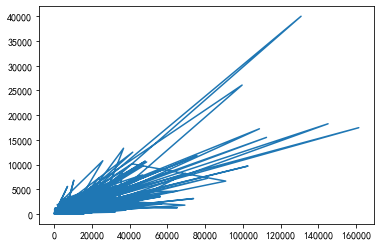

In [58]:
plt.plot(region_1.step,region_1.ord_qty)

In [59]:
features = region_1[[ 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price','Year',
       'Month', 'day', 'day of the week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'is_workday', 'is_holiday', 'sales','step', 'step^2']]
                       
targets = region_1['ord_qty']

In [60]:
# split data
X_train,X_val,y_train,y_val = train_test_split(features,targets,test_size=0.05,shuffle=False)

In [61]:
model1 = LinearRegression()
model1.fit(X_train, y_train)
predictions = model1.predict(X_val)
smape(y_val,predictions)

98.03167520705503

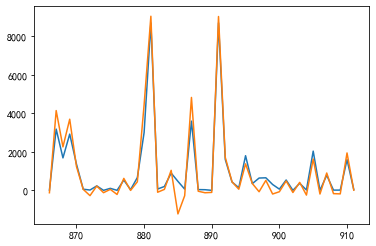

In [62]:
plt.plot(X_val.index,y_val)
plt.plot(X_val.index,predictions)

In [63]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

params = {'lambda': 0.5364370292238032, 'alpha': 7.216972825550576, 
          'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.008, 
          'n_estimators': 1500, 'max_depth': 17, 'min_child_weight': 1}
xgb = xgb.XGBRegressor(n_estimators=1000)
xgb.fit(X_train, y_train,
        eval_set=[(X_train,y_train),(X_val, y_val)],
        early_stopping_rounds=25,
       verbose=False)

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

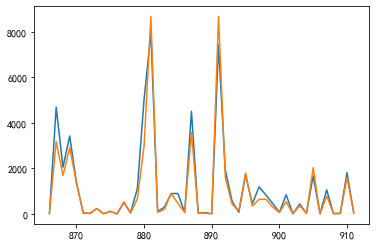

In [64]:
predictions = xgb.predict(X_val)
plt.plot(X_val.index,predictions)
plt.plot(X_val.index,y_val)

In [65]:
smape(y_val,predictions)

30.41483734354367

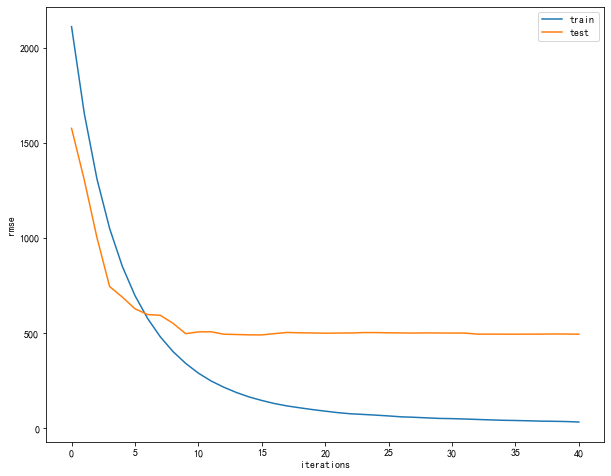

In [66]:
from matplotlib import pyplot
# plot learning curves
results = xgb.evals_result()
plt.figure(figsize=(10, 8))
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
plt.xlabel('iterations')
plt.ylabel('rmse')
# show the plot
pyplot.show()

In [67]:
features.columns

Index(['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code',
       'sales_chan_name', 'item_price', 'Year', 'Month', 'day',
       'day of the week', 'quarter', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end',
       'is_workday', 'is_holiday', 'sales', 'step', 'step^2'],
      dtype='object')

In [68]:
features = train_df[[ 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price','Year',
       'Month', 'day', 'day of the week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'is_workday', 'is_holiday', 'sales','step', 'step^2']]
targets = train_df['ord_qty']

In [69]:
# split data
X_train,X_val,y_train,y_val = train_test_split(features,targets,test_size=0.05,shuffle=False)

In [70]:
model1 = LinearRegression()
model1.fit(X_train, y_train)
smape(y_val,model1.predict(X_val))

89.17576112785504

In [71]:
model1.predict(X_val)

array([ 51.57786791,  13.72581146,  59.84545648, ...,  16.28891462,
       228.6741891 , 131.77527986])

In [93]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

xgb = xgb.XGBRegressor(n_estimators=1200)
xgb.fit(X_train, y_train,
        eval_set=[(X_train,y_train),(X_val, y_val)],
        early_stopping_rounds=30,
       verbose=False)

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [94]:
predictions = xgb.predict(X_val)
smape(y_val,predictions)

2.0951154199698863

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

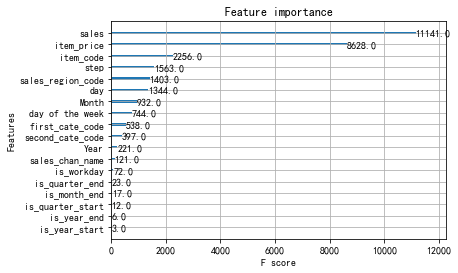

In [95]:
plot_importance(xgb)

In [87]:
results = xgb.evals_result()

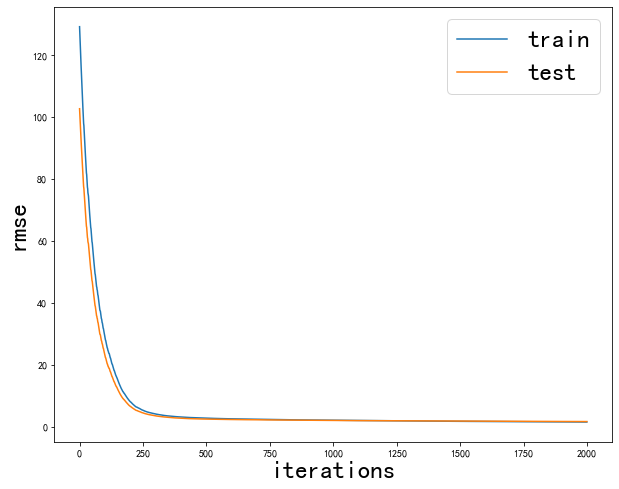

In [96]:
from matplotlib import pyplot
# plot learning curves
plt.figure(figsize=(10, 8))
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend(fontsize = 25)
plt.xlabel('iterations',fontsize = 25)
plt.ylabel('rmse',fontsize = 25)
# show the plot
pyplot.show()

In [78]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
cat.fit(X_train,y_train,eval_set=(X_val,y_val),early_stopping_rounds=500,verbose=False)
smape(y_val,cat.predict(X_val))

5.581832301982231

In [ ]:
#超参数调整 

In [79]:
def objective(trial,X,y, name='xgb'):
    params = param = {
        'tree_method':'gpu_hist',  
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'eta': trial.suggest_float('eta', 1e-5, 0.1),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical( 
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300,1000, 1500,2000, 3000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,15,17]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
        'random_state':15
    }

    model =  XGBRegressor(**params)
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=50,verbose=False)


    train_score = np.round(np.sqrt(mean_squared_error(y_train, model.predict(X_train))), 5)
    test_score = np.round(np.sqrt(mean_squared_error(y_val, model.predict(X_val))), 5)
                  
    print(f'TRAIN RMSE : {train_score} || TEST RMSE : {test_score}')
                  
    return test_score

In [80]:
params ={'lambda': 0.0012338191278124635, 'alpha': 3.284395992431614, 'eta': 0.09886834650237164, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 2000, 'max_depth': 5, 'min_child_weight': 3}

In [81]:
xgb = XGBRegressor(**params)
xgb.fit(X_train, y_train,
        eval_set=[(X_train,y_train),(X_val, y_val)],
        early_stopping_rounds=60,
       verbose=False)

XGBRegressor(alpha=3.284395992431614, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eta=0.09886834650237164,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', lambda=0.0012338191278124635,
             learning_rate=0.018, max_bin=256, max_cat_threshold=64,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=0, ...)

In [82]:
predictions = xgb.predict(X_val)
smape(y_val,predictions)

6.086178930531455

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

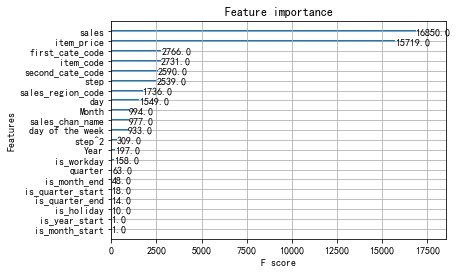

In [83]:
plot_importance(xgb)

In [84]:
results = xgb.evals_result()

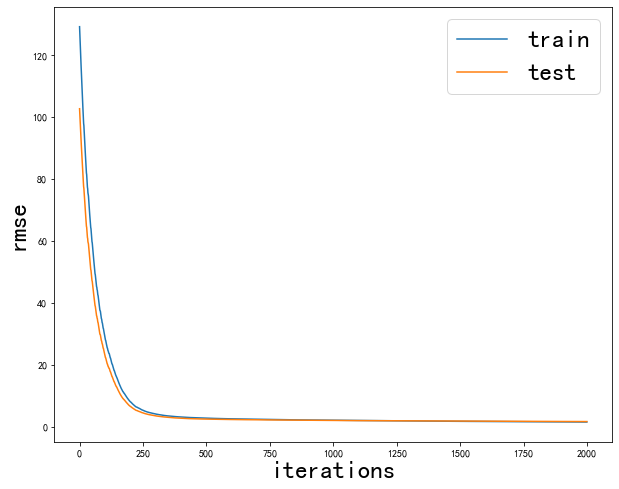

In [92]:
from matplotlib import pyplot
# plot learning curves
results = xgb.evals_result()
plt.figure(figsize=(10, 8))
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend

pyplot.legend(fontsize=25)
plt.xlabel('iterations',fontsize = 25)
plt.ylabel('rmse',fontsize = 25)
# show the plot
pyplot.show()

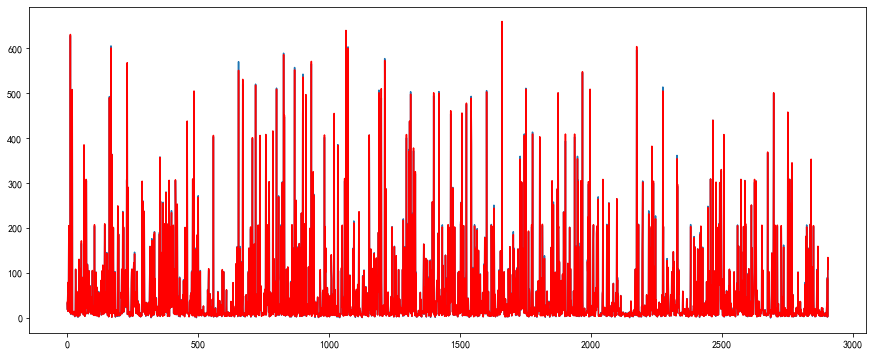

In [86]:
y = predictions
x = range(len(predictions))
plt.figure(figsize=(15,6))
plt.plot(x,y)
plt.plot(x,y_val,'red')